In [13]:
import galprime as grp

from photutils import morphology
from photutils.isophote import EllipseGeometry, Ellipse
from photutils.aperture import EllipticalAperture

from matplotlib import pyplot as plt
import numpy as np

In [7]:
def estimate_morphology(cutout, mask=None):
    """
    Estimate the morphology of a galaxy.
    """
    try:
        morph = morphology.data_properties(cutout, mask=mask).to_table()
        x0, y0 = morph['xcentroid'][0], morph['ycentroid'][0]
        pa = morph['orientation'][0]
        a, b = morph['semimajor_sigma'][0], morph['semiminor_sigma'][0]
        return EllipseGeometry(x0=x0, y0=y0,  sma=a.value, eps=1 - b/a, pa=np.deg2rad(pa.value))
    except Exception as e:
        print(f"Error: {e}")
        return None


def convert_ellipsegeometry_to_ellipticalaperture(eg):
    b = eg.sma * (1 - eg.eps)
    return EllipticalAperture(positions=(eg.x0, eg.y0), a=eg.sma, b=b.value, theta=eg.pa)

10
10


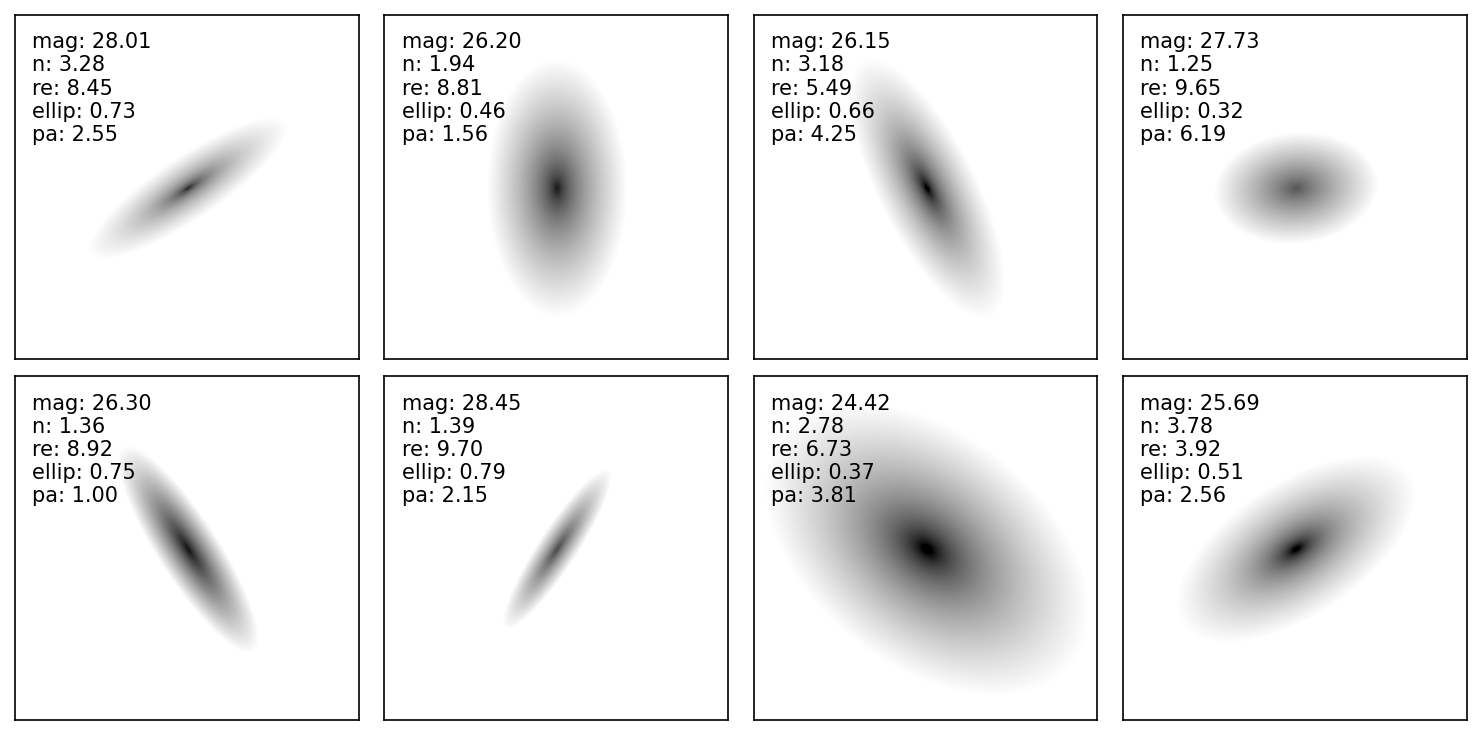

In [8]:
models = grp.gen_sersic_models(10, width=(151, 151))

print(len(models.cutout_data))
models.show_cutouts(method="log", vmin=-5, vmax=-1, ncols=4, model_data=models.cutout_data)



In [17]:

class PoorFitException(Exception):
    pass


def isophote_fitting(data, config):
    fail_count, max_fails = 0, 100
    linear = config.get("EXTRACTION", {}).get("LINEAR", False)
    step = config.get("EXTRACTION", {}).get("STEP", 0.1)
    fix_center = config.get("EXTRACTION", {}).get("FIX_CENTER", False)
    maxit = config.get("EXTRACTION", {}).get("MAXIT", 100)

    cutout_halfwidth = max((data.shape[0] // 2, data.shape[1] // 2))
    maxrit = config.get("EXTRACTION", {}).get("MAXRIT", cutout_halfwidth / 3)

    def attempt_fit(geo):
        flux = Ellipse(data, geo)
        try:
            fitting_list = flux.fit_image(maxit=maxit, maxsma=cutout_halfwidth, step=step, linear=linear,
                                        maxrit=maxrit, fix_center=fix_center)
            if len(fitting_list) > 0:
                return fitting_list
            else:
                raise PoorFitException()
        except Exception as e:
            raise PoorFitException()
    



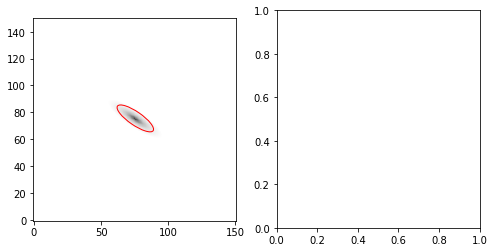

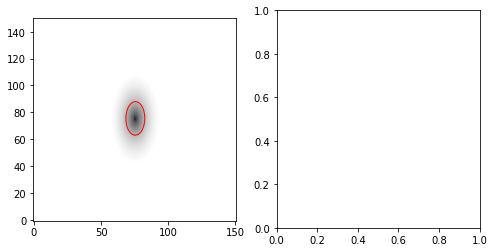

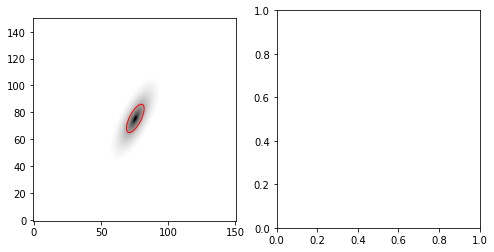

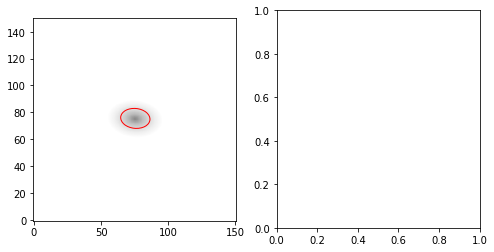

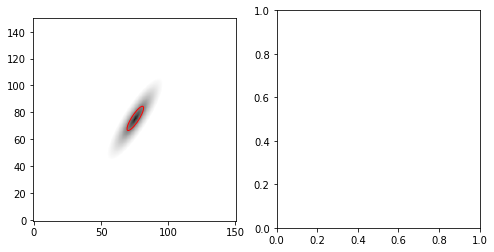

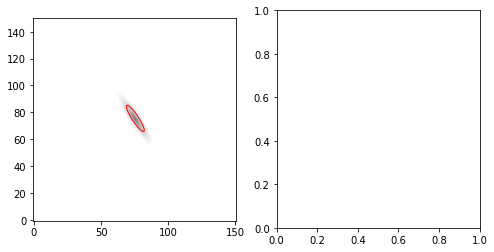

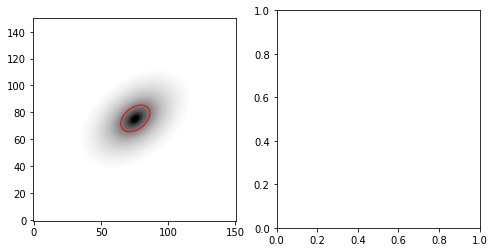

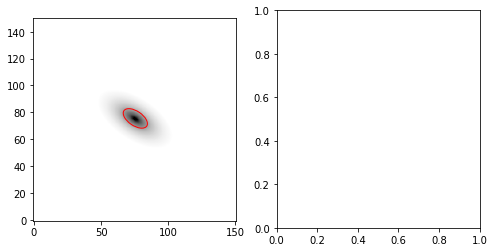

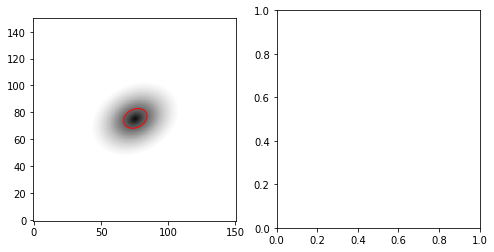

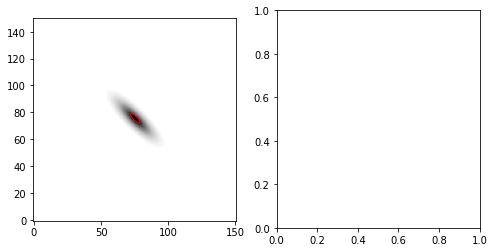

In [12]:
for cutout in models.cutouts:
    morph = estimate_morphology(cutout)
    geo = convert_ellipsegeometry_to_ellipticalaperture(morph)

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
    ax[0].imshow(np.log10(cutout), cmap='Greys', origin='lower', vmin=-4, vmax=-1)
    geo.plot(ax=ax[0], color='red')

    isolist = grp.isophote_fitting(cutout)
    